In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.nn import Linear
import time
import networkx as nx
import matplotlib.pyplot as plt

from sdcn.utils import load_data, load_graph
from sdcn.GNN import GNNLayer

from sdcn.evaluation import modularity
from myutils import load_ordered_graph
from mnn.decoder import BerpoDecoder
from mnn.nocd_utils import plot_sparse_clustered_adjacency



In [2]:
# cuda
cuda = torch.cuda.is_available()
device = torch.device( "cuda" if cuda else "cpu")
print("use cuda: {}".format( cuda))

# dataset
name = 'bio72'

# Graph matrix (coo_matrix, csr_matrix, dense )
A, A_csr, A_dense = load_graph( name )
A = A.cuda()
A_dense = torch.Tensor(A_dense).to(device)
train_graph_path = './mygraph/' + name + '_edgelist.txt'
print('training graph({}) read over'.format(train_graph_path))

# G: networkx format 
eval_graph_path = './mygraph/' +  name + '.adjlist'
G_eval = load_ordered_graph( eval_graph_path )
print('evaluating graph({}) read over'.format(eval_graph_path))

# Features dataset
dataset = load_data( name )
N, K = len(dataset.x), len(dataset.x[0])
print('features shape {}(nodes) * {}(columns) '.format(N,K))

# pretrain AutoEncoder data
pretrain_path = './pretrain/' + name + '.pkl'

# Loss class
decoder = BerpoDecoder(N, A_csr.nnz, balance_loss=False)
print('graph has {}(edges symmetrically) '.format(A_csr.nnz))


use cuda: True
training graph(./mygraph/dpwk_edgelist.txt) read over
initial G nodes 25023,edges 2299958
after G nodes 25023,edges 2324981
evaluating graph(./mygraph/dpwk.adjlist) read over
reading dpwk.txt, please wait for about a thousand years....
features shape 25023(nodes) * 128(columns) 
graph has 4624939(edges symmetrically) 


In [3]:
# HyperParameters
# dimensions: initially n_input,500,500,2000,10 
n_input = K
# communities 
n_clusters = 8

 # 4 hidden layers, not good result (0.19,0.17...)
n_1, n_2, n_z = 512, 2048, 16
n_d2, n_d1 = n_2, n_1


# learning rates
pretrain_lr = 1e-3
# train lr : 1e-4 is too slow,  1e-3 is too fast, only GCN 1e-4,5e-4 doesnt move
train_lr = 1e-4

# train epochs
pretrain_epochs = 100 # 30 # 100 # 200
train_epochs = 200 
# how often to compute community
display_step = train_epochs     


# TODO
dropout = 0.5            # whether to use dropout
batch_norm = True        # whether to use batch norm
balance_loss = True      # whether to use balanced loss
stochastic_loss = False  # whether to use stochastic or full-batch training
batch_size = 20000       # batch size (only for stochastic training)


In [4]:
# AutoEncoder:    x -> n_1 -> n_2 -> n_3 -> z 
#                 \                         \
# initial:     x_rec<- d_1 <- d_2 <- d_3  <-
class AE(nn.Module):

    def __init__(self  ):
        super(AE, self).__init__()
        
        self.enc_1 = Linear(n_input, n_1)
        self.enc_2 = Linear(n_1, n_2)
        self.z_layer = Linear(n_2, n_z)
        self.dec_2 = Linear(n_z, n_d2)
        self.dec_1 = Linear(n_d2, n_d1)
        self.x_bar_layer = Linear(n_d1, n_input)
        
    def forward(self, x):
        enc_h1 = F.relu(self.enc_1(x))
        enc_h2 = F.relu(self.enc_2(enc_h1))
        z_ae = self.z_layer(enc_h2)
        dec_h2 = F.relu(self.dec_2(z_ae))
        dec_h1 = F.relu(self.dec_1(dec_h2))
        x_bar = self.x_bar_layer(dec_h1)
        return x_bar, enc_h1, enc_h2,  z_ae
    
    """Return the weight matrices of the model."""
    def get_weights(self):
        return [w for n, w in self.named_parameters() if 'bias' not in n]

def pretrain_ae( ):
    train_loader = DataLoader( dataset , batch_size=256, shuffle=True )
    optimizer = Adam( model.parameters(), lr= pretrain_lr )    
    for epoch in range( pretrain_epochs ):
        # adjust_learning_rate(optimizer, epoch)
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.cuda()

            x_bar, _, _, _= model(x)
            loss = F.mse_loss(x_bar, x)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            x = torch.Tensor(dataset.x).cuda().float()
            x_bar, _, _, z_ae = model(x)
            loss = F.mse_loss(x_bar, x)
            print('{} loss: {}'.format(epoch, loss))           
        
        if epoch == pretrain_epochs-1:
            print('writing to{}...'.format( pretrain_path ))
            torch.save(model.state_dict(), pretrain_path )
    
    

In [5]:
# do pretrain
model = AE( ).cuda()
print( 'pretrain model: {} \nlearning rate: {} \npretrain_epochs: {}' \
      .format( model, pretrain_lr, pretrain_epochs) )
# dataset already read 

# do practical pretrain
# pretrain_ae( )

pretrain model: AE(
  (enc_1): Linear(in_features=128, out_features=512, bias=True)
  (enc_2): Linear(in_features=512, out_features=2048, bias=True)
  (z_layer): Linear(in_features=2048, out_features=16, bias=True)
  (dec_2): Linear(in_features=16, out_features=2048, bias=True)
  (dec_1): Linear(in_features=2048, out_features=512, bias=True)
  (x_bar_layer): Linear(in_features=512, out_features=128, bias=True)
) 
learning rate: 0.001 
pretrain_epochs: 100


In [10]:
# GCN
class SDCN(nn.Module):
    def __init__(self, n_input, n_1, n_2,  n_z,  n_d2, n_d1, n_clusters, v=1):
        super(SDCN, self).__init__()
        
        # AutoEncoder for intra information    #  symmetric 
        self.ae = AE(  )
        self.ae.load_state_dict(torch.load( pretrain_path, map_location='cpu'))

        # GCN for inter information
        self.gnn_1 = GNNLayer(n_input, n_1)
        self.gnn_2 = GNNLayer(n_1, n_2)
        self.gnn_3 = GNNLayer(n_2, n_z)
        self.gnn_4 = GNNLayer(n_z, n_clusters)

    def forward(self, x, A):
        
        # DNN Module    # only GCN is bad!
        x_bar, tra1, tra2, z_ae = self.ae(x)
        
        # GCN Module
        h1 = self.gnn_1(x, A)
        h2 = self.gnn_2(h1+tra1, A)
        h3 = self.gnn_3(h2+tra2, A)
        h4 = self.gnn_4(h3+z_ae, A, active=False)
        predict = F.softmax( h4, dim=1)  # if relu modul 0.20,0.025
        return x_bar, predict, z_ae
       
    """Return the weight matrices of the model."""
    def get_weights(self):
        return [w for n, w in self.named_parameters() if 'bias' not in n]

    
"""Get L2 loss for model weights."""
def l2_reg_loss(sdcn_model ):
    loss = 0.0
    for w in sdcn_model.get_weights():
        loss += w.pow(2.).sum()
    for w in sdcn_model.ae.get_weights():
        loss += w.pow(2.).sum()
    return loss  


In [11]:
sdcn = SDCN(   n_input, n_1, n_2, 
                n_z, n_d2, n_d1, 
                n_clusters, v=1.0).to(device)
print(sdcn)
optimizer = Adam(sdcn.parameters(), lr= train_lr )
data = torch.Tensor(dataset.x).to(device)    # X
    
def train_sdcn( ):
    # initial dimensions 500,500,2000,10,2000,500,500
    '''
    # TODO only AutoEncoder result
    with torch.no_grad():
        _, _, _, z_ae = model.ae(data)
    '''
    # training...
    for epoch in range(train_epochs):
        
        # TODO F.relu(  )
        x_bar, pred, z_ae  = sdcn(data, A) #  x_bar, pred, z_ae 
        
        '''
        # my initial naive loss
        re_loss = F.mse_loss(x_bar, data)
        # 社区发现重构边损失
        A_rec = torch.mm( z_sdcn, z_sdcn.T ).cuda()     
        g_re_loss = F.mse_loss( A_rec, A_dense ) # not good ( 0.26 to 0.20 )
        # 72维features重构、25023*25023图社区划分结果重构损失加权
        loss =  0.001 * g_re_loss + re_loss          
        '''
        
        # TODO 自适应加权损失（大的损失值有更大的减小速度） # 正则化项
        # 0.01, 1 ( ret:0.26 )  0.1,1 (ret:0.2217) 
        # predict result  #Z 
        res = pred.data.cpu().numpy().argmax(1)  
        x_re_loss = F.mse_loss(x_bar, data)
        bonouli_loss = 0.01 * decoder.loss_full( pred, A_csr ) # 0.05 not good(modul 0.01)
        reg_loss = 0 *  l2_reg_loss( sdcn ) # not good ( 0.26 to 0.22 )
        loss = x_re_loss + bonouli_loss + reg_loss  
        print('loss of epoch {}:{}, x_re:{},bonouli:{}, reg_loss:{} '.format(epoch, loss, x_re_loss, bonouli_loss,reg_loss ))
        
        # last modularity evaluation 
        if ( epoch+1 ) % display_step == 0 : # how often to compute validation loss:    
            pred_modul = modularity(G_eval, res )
            print('\nepoch {}  modularity: {:.6f}\n'.format(epoch,pred_modul))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

SDCN(
  (ae): AE(
    (enc_1): Linear(in_features=128, out_features=512, bias=True)
    (enc_2): Linear(in_features=512, out_features=2048, bias=True)
    (z_layer): Linear(in_features=2048, out_features=16, bias=True)
    (dec_2): Linear(in_features=16, out_features=2048, bias=True)
    (dec_1): Linear(in_features=2048, out_features=512, bias=True)
    (x_bar_layer): Linear(in_features=512, out_features=128, bias=True)
  )
  (gnn_1): GNNLayer()
  (gnn_2): GNNLayer()
  (gnn_3): GNNLayer()
  (gnn_4): GNNLayer()
)


In [12]:
print('begin time:{}'.format(time.asctime(time.localtime(time.time()))))    # time 
train_sdcn( )
print('end time:{}'.format(time.asctime(time.localtime(time.time()))))    # time 

begin time:Tue Apr 20 21:26:40 2021
loss of epoch 0:0.02890995889902115, x_re:0.027415821328759193,bonouli:0.001494138385169208, reg_loss:0.0 
loss of epoch 1:0.02832687273621559, x_re:0.026865912601351738,bonouli:0.0014609595527872443, reg_loss:0.0 
loss of epoch 2:0.02806880883872509, x_re:0.026623187586665154,bonouli:0.0014456220669671893, reg_loss:0.0 
loss of epoch 3:0.02787119150161743, x_re:0.02643589861690998,bonouli:0.0014352926518768072, reg_loss:0.0 
loss of epoch 4:0.027689728885889053, x_re:0.026260484009981155,bonouli:0.0014292442938312888, reg_loss:0.0 
loss of epoch 5:0.02753964252769947, x_re:0.026114219799637794,bonouli:0.0014254228444769979, reg_loss:0.0 
loss of epoch 6:0.027426889166235924, x_re:0.026004375889897346,bonouli:0.0014225138584151864, reg_loss:0.0 
loss of epoch 7:0.02734117954969406, x_re:0.025921061635017395,bonouli:0.0014201183803379536, reg_loss:0.0 
loss of epoch 8:0.02727026492357254, x_re:0.025852402672171593,bonouli:0.0014178622514009476, reg_lo

loss of epoch 75:0.026046866551041603, x_re:0.02464441768825054,bonouli:0.001402449095621705, reg_loss:0.0 
loss of epoch 76:0.02604099176824093, x_re:0.024638626724481583,bonouli:0.0014023652765899897, reg_loss:0.0 
loss of epoch 77:0.026035204529762268, x_re:0.02463291399180889,bonouli:0.001402290421538055, reg_loss:0.0 
loss of epoch 78:0.026029514148831367, x_re:0.024627288803458214,bonouli:0.0014022248797118664, reg_loss:0.0 
loss of epoch 79:0.026023918762803078, x_re:0.0246217492967844,bonouli:0.0014021696988493204, reg_loss:0.0 
loss of epoch 80:0.026018410921096802, x_re:0.024616284295916557,bonouli:0.0014021274400874972, reg_loss:0.0 
loss of epoch 81:0.02601298689842224, x_re:0.024610886350274086,bonouli:0.0014020998496562243, reg_loss:0.0 
loss of epoch 82:0.026007646694779396, x_re:0.024605566635727882,bonouli:0.0014020808739587665, reg_loss:0.0 
loss of epoch 83:0.02600237727165222, x_re:0.024600312113761902,bonouli:0.0014020648086443543, reg_loss:0.0 
loss of epoch 84:0.

loss of epoch 150:0.02574020065367222, x_re:0.024340389296412468,bonouli:0.0013998114736750722, reg_loss:0.0 
loss of epoch 151:0.025737032294273376, x_re:0.02433726377785206,bonouli:0.0013997682835906744, reg_loss:0.0 
loss of epoch 152:0.025734011083841324, x_re:0.024334248155355453,bonouli:0.0013997626956552267, reg_loss:0.0 
loss of epoch 153:0.025731101632118225, x_re:0.02433139644563198,bonouli:0.0013997048372402787, reg_loss:0.0 
loss of epoch 154:0.025728071108460426, x_re:0.024328364059329033,bonouli:0.0013997062342241406, reg_loss:0.0 
loss of epoch 155:0.02572491392493248, x_re:0.024325262755155563,bonouli:0.001399650820530951, reg_loss:0.0 
loss of epoch 156:0.025721918791532516, x_re:0.024322280660271645,bonouli:0.0013996377820149064, reg_loss:0.0 
loss of epoch 157:0.02571902610361576, x_re:0.024319425225257874,bonouli:0.0013996002962812781, reg_loss:0.0 
loss of epoch 158:0.025715932250022888, x_re:0.024316351860761642,bonouli:0.0013995794579386711, reg_loss:0.0 
loss of

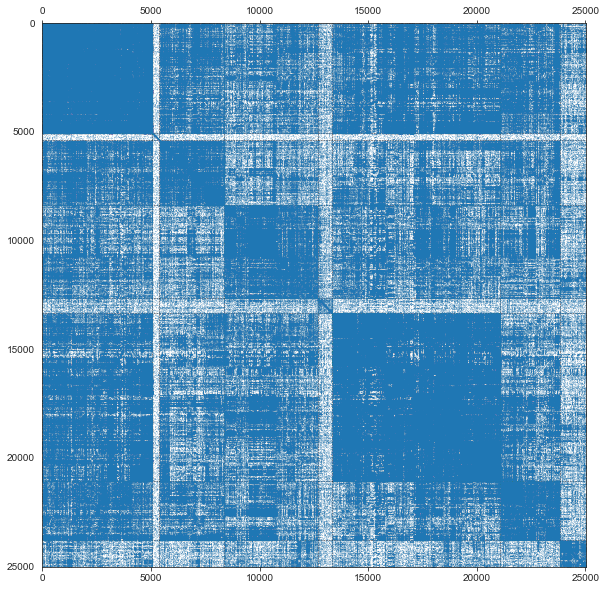

In [13]:
# draw # pred 是softmax的结果
x_bar, pred, z_ae  = sdcn(data, A) # x_bar, pred, z_ae 
plt.figure(figsize=[ 10, 10 ])
# res = pred.data.cpu().numpy().argmax(1)  
z = np.argmax(pred.data.cpu(), 1)
o = np.argsort( z )
plot_sparse_clustered_adjacency(A_csr, K, z, o, markersize=0.05)
